In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/github_repos/Fake-news-detection-VN/Using phoBERT/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!nvidia-smi

Wed Dec  9 12:30:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    23W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Device
import tensorflow as tf
from tensorflow.python.client import device_lib
print('Current Device: ', tf.test.gpu_device_name() + '\n')
device_lib.list_local_devices()

Current Device:  /device:GPU:0



[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 494440519009580727, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 9185515154224118055
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16276993471112806769
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15473775744
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11124252688862547093
 physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"]

In [1]:
!pip install transformers
!pip install schedule

     |████████████████████████████████| 1.4MB 7.0MB/s 
     |████████████████████████████████| 2.9MB 32.8MB/s 
     |████████████████████████████████| 890kB 54.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=d9a512e24a89db27e84f8255436a8cb29110049face213fc9b8e50a1795a4f15
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
from sklearn.model_selection import train_test_split

import schedule
import time
from datetime import datetime as dt
import datetime
import os
import random
import math
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm.notebook import tqdm
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.python.keras import initializers
import re
import string

import transformers
from transformers import TFAutoModel, AutoTokenizer, TFAutoModelForSequenceClassification, PhobertTokenizer

print('Using Tensorflow version:', tf.__version__)
print('Using Transformers version:', transformers.__version__)

# import warnings
# warnings.filterwarnings('ignore')
tqdm.pandas()

Using Tensorflow version: 2.3.0
Using Transformers version: 4.0.1


In [3]:
# Install the vncorenlp python wrapper
!pip install vncorenlp

# # Download VnCoreNLP-1.1.1.jar & its word segmentation component (i.e. RDRSegmenter) 
# !mkdir -p vncorenlp/models/wordsegmenter
# !wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
# !wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
# !wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
# !mv VnCoreNLP-1.1.1.jar vncorenlp/ 
# !mv vi-vocab vncorenlp/models/wordsegmenter/
# !mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

     |████████████████████████████████| 2.7MB 6.4MB/s 
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-cp36-none-any.whl size=2645934 sha256=2a3cf032cba23d353f142f6f3c91904303e74d3ebf85920f344302f37cc42305
  Stored in directory: /root/.cache/pip/wheels/09/54/8b/043667de6091d06a381d7745f44174504a9a4a56ecc9380c54
Successfully built vncorenlp


In [4]:
MAX_LEN = 256
BATCH_SIZE = 16

In [5]:
n_epochs = 5
n_folds = 5
SEED = 1510

now = dt.now()
curr_time = now.strftime("%d%m%Y") 

DISPLAY=1 # USE display=1 FOR INTERACTIVE
exp = f'phobert+auxiliary_{MAX_LEN}_len'

# output_dir = f'../outputs_private_data/{exp}_models/{curr_time}'

output_dir = '/content/drive/MyDrive/github_repos/Fake-news-detection-VN/outputs_private_data/phobert+auxiliary_256_len_models/08122020'
os.makedirs(output_dir, exist_ok=True)

In [6]:
roberta = 'vinai/phobert-base' 
# roberta_tokenizer = AutoTokenizer.from_pretrained(roberta)
roberta_tokenizer = PhobertTokenizer.from_pretrained(roberta)
# roberta_model = TFAutoModel.from_pretrained(roberta)

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [7]:
def seed_all(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

In [8]:
seed_all(SEED)

In [ ]:
def kfold_split(train_df, n_folds):
    train_df["fold"] = 0
    for label in tqdm(train_df["label"].unique()):
        class_index = train_df[train_df["label"]==label].index.tolist()
        random.shuffle(class_index)
        fold_len = int(len(class_index)/n_folds)
        for fold in range(n_folds):
            train_df.loc[class_index[fold*fold_len:(fold+1)*fold_len], 'fold'] = fold
    return train_df

In [ ]:
warmup_train_df = pd.read_csv("/content/drive/MyDrive/github_repos/Fake-news-detection-VN/data/warmup_training_dataset.csv", index_col="id")

public_train_df = pd.read_csv("/content/drive/MyDrive/github_repos/Fake-news-detection-VN/data/public_train.csv")
public_test_df = pd.read_csv("/content/drive/MyDrive/github_repos/Fake-news-detection-VN/data/private_test.csv")

# TODO: make use of warmup_test_df
train_df = pd.concat([warmup_train_df, public_train_df]).drop_duplicates()
train_df = kfold_split(train_df, n_folds)
train_df.to_csv(f'/content/drive/MyDrive/github_repos/Fake-news-detection-VN/data/train_{n_folds}_folds.csv', index=False)

In [12]:
from vncorenlp import VnCoreNLP

class VnCoreTokenizer():
    def __init__(self, path="/content/drive/MyDrive/github_repos/Fake-news-detection-VN/Using phoBERT/vncorenlp/VnCoreNLP-1.1.1.jar"):
        self.rdrsegmenter = VnCoreNLP(path,
                                      annotators="wseg", max_heap_size='-Xmx500m')
    def tokenize(self, text: str) -> str:
        sentences = self.rdrsegmenter.tokenize(text)
        output = ""
        for sentence in sentences:
            output += " ".join(sentence)
        return output

# tokenizer = VnCoreTokenizer("/content/drive/MyDrive/github_repos/Fake-news-detection-VN/Using phoBERT/vncorenlp/VnCoreNLP-1.1.1.jar")
# print(tokenizer.tokenize("Tôi là sinh viên đại học Bách Khoa Hà Nội"))

In [13]:
def clean_post(text):
    # Remove hashtag
    text = re.sub(r'#\w*','', str(text))
    # Remove tickers
    text = re.sub(r'\$\w*', '', text)
    # Remove URL, RT, mention(@)
    text=  re.sub(r'http(\S)+', '',text)
    text=  re.sub(r'https(\S)+', '',text)
    text=  re.sub(r'http ...', '',text)
    text = re.sub(r'@[\S]+','',text)
    
    # Remove repeating syllables
    text = re.sub(r'(\D)\1+', r'\1', text)

    # Remove words with > 7 letters ("nghiêng" - longest)
    text = re.sub(r'\b[a-zA-Z]{8,}\b', '', text)

    # Remove other characters
    # text = re.sub(r'_', ' ' , text)
    text = re.sub(r'\:\D{1}', ' ' , text)
    text = re.sub(r'<url>', '' , text)
    text = re.sub(r'< url >', '' , text)
    text = re.sub(r'<URL>', '' , text)
    text = re.sub(r'< URL >', '' , text)
     # Remove emoji
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) # no emoji
    
    # Remove whitespace
    text = re.sub(r'\s\s+',' ', text)
    text = re.sub(r'[ ]{2, }',' ',text)
    return text


In [14]:
cleaned_text = clean_post("https://soict.hust.edu.vn/ #sad Ghê chưa, <url> 😂 Tôi là cảnh_sát khu vực HBT, hãy gọi cho tôi, sdt của tôi là 0967374782")
print(cleaned_text)

 Ghê chưa, Tôi là cảnh_sát khu vực HBT, hãy gọi cho tôi, sdt của tôi là 0967374782


In [15]:
# %%time
train_df_path = '/content/drive/MyDrive/github_repos/Fake-news-detection-VN/data/train_5_folds.csv'
test_df_path = '/content/drive/MyDrive/github_repos/Fake-news-detection-VN/data/private_test.csv'

train_df = pd.read_csv(train_df_path)
test_df = pd.read_csv(test_df_path)

train_df['post_message'] = train_df['post_message'].apply(clean_post)
test_df['post_message'] = test_df['post_message'].apply(clean_post)

In [16]:
vncore_tokenizer = VnCoreTokenizer()

train_df["post_message"] = train_df["post_message"].progress_apply(vncore_tokenizer.tokenize)
test_df["post_message"] = test_df["post_message"].progress_apply(vncore_tokenizer.tokenize)

train_df["post_message"] = train_df["post_message"].astype(str)
test_df["post_message"] = test_df["post_message"].astype(str)

train_df["timestamp_post"] = train_df["timestamp_post"].astype(float)
test_df["timestamp_post"] = test_df["timestamp_post"].astype(float)

In [ ]:
train_df.head()

,user_name,post_message,timestamp_post,num_like_post,num_comment_post,num_share_post,label,id,fold
0,2.1670747238331e+18,"Cần các bậc phụ_huynh xã Ngũ_Thái lên_tiếng , ...",1.584426e+09,45,15,8,1,NaN,0
1,7.3684975478124e+18,KÊU_GỌI ĂN_CHAY CẦU_NGUYỆN XIN CHÚA CỨU KHỎI D...,1.581363e+09,979,39,138,1,NaN,0
2,-5.7541426252803e+18,"Giàn khoan dầu_khí gặp sự_cố , chết người !Già...",1.587042e+09,85,13,61,1,NaN,4
3,4.1779353088497e+18,"Thuận_Lợi có ca dương_tính CV19 rồi đó , mọi n...",1.596449e+09,114,12,5,1,NaN,1
4,5.540309800746e+18,Sa_Pa cho 9 người khách nước_ngoài đi cùng chu...,1.583548e+09,166,4,21,1,NaN,1


In [ ]:
test_df.tail(10)

,id,user_name,post_message,timestamp_post,num_like_post,num_comment_post,num_share_post
1636,7651,980fcd8cd5324168a29e21a3f1e533dd,Biến này sock mn tự bảo_vệ mình ! đã trốn khỏi...,1.581848e+09,NaN,NaN,NaN
1637,7652,499e88d64b6cc2baf28ad1b674480d09,TỪ 0 GIỜ THỨ_BẢY 28-3 GẦN NHƯ GIỚI_NGHIÊM TOÀN...,1.585241e+09,NaN,NaN,NaN
1638,7653,d3a0d35eae791765acc379cce333fbc6,Mọi người cảnh giá nhé . trưa hôm_nay cô_mình ...,1.584342e+09,NaN,NaN,NaN
1639,7654,1fbbc28bca8dff1e785226465a8daa54,"Hôm_qua , Bộ_trưởng Nông_nghiệp Nguyễn_Xuân_Cư...",1.592122e+09,63.0,30,4
1640,7655,4ba8f450674944420399297cae0d3491,Thảm_khốc 97 người chết là do phi_công mải nói...,1.593007e+09,NaN,NaN,NaN
1641,7656,4b3099585793c94c549f4a2fda9c8709,Đây là khu tác_nghiệp dã_chiến của các phóng_v...,1.586149e+09,14029.0,50,142
1642,7657,ccf2286e41cd4654a445f605a17a621f,Ô_tô 4 chỗ chạy hướng từ Ngã ba Đồng Lộc về hu...,1.583978e+09,NaN,NaN,0
1643,7658,37e84ae817d024d201b8478236d9117f,Trong khi tuyến cáp_quang biển AG đang bị lỗi ...,1.590221e+09,NaN,NaN,48
1644,7659,f3317e52aa79b261db534a38e7f7c360,BN91 ĐƯỢC ĐÁNH_GIÁ LÀ KHÔNG CẦN PHẢI GHÉP PHỔI...,1.592367e+09,NaN,50,155
1645,7660,2e00583d046766d461afab67a7855530,Hải_Phòng lên_tiếng về thông_tin mua máy xét_n...,1.587793e+09,NaN,76,NaN


In [ ]:
train_df.shape

(5172, 9)

In [ ]:
test_df.shape

(1646, 7)

In [ ]:
# nan_dict = {"num_like_post":-2,"num_comment_post":-2, "num_share_post":-2}
# unknown_dict = {"num_like_post":-2,"num_comment_post":-2, "num_share_post":-2}

# def extract_num(text):
#     return re.findall("\d+", text)
# def vlsp_impute(text, field):
#     if type(text)=="NoneType":
#         return unknown_dict[field]
#     elif type(text)!=str:
#         if math.isnan(text):
#             return nan_dict[field] 
#     elif text=="unknown":        
#         return unknown_dict[field]
#     else:
#         try:
#             return int(extract_num(text))
#         except:
#             print(text)
#             return nan_dict[field]

In [ ]:
Counter(test_df["num_like_post"])["unknown"]

0

In [ ]:
sum(test_df["num_like_post"].isna())

616

In [ ]:
Counter(train_df["num_share_post"])["unknown"]

121

In [ ]:
sum(train_df["num_share_post"].isna())

937

In [ ]:
Counter(train_df["num_comment_post"])["unknown"]

121

In [ ]:
sum(train_df["num_comment_post"].isna())

18

In [17]:
def extract_num(text):
    if type(text)==str:
        if text=="unknown":
            return math.nan
        return re.findall("\d+", text)[0]
    return text

In [ ]:
for col in ["timestamp_post", "num_like_post", "num_comment_post", "num_share_post"]:
    train_df[col] = train_df[col].apply(extract_num)
    train_df[col] = train_df[col].astype(float)
    train_df[col] = train_df[col].fillna(-train_df[col].mean())
    test_df[col] = test_df[col].apply(extract_num)
    test_df[col] = test_df[col].astype(float)
    test_df[col] = test_df[col].fillna(-test_df[col].mean())

In [ ]:
# for field in tqdm(["num_like_post", "num_comment_post", "num_share_post"]):
# #     with open(f"train_{field}.txt", "w") as f:
# #         f.write("\n".join([str(x) for x in train_df[field].unique()]))
# #     with open(f"test_{field}.txt", "w") as f:
# #         f.write("\n".join([str(x) for x in test_df[field].unique()]))
#     test_df[field] =  test_df[field].apply(lambda text: vlsp_impute(text, field)).astype(int)
#     train_df[field] =  train_df[field].apply(lambda text: vlsp_impute(text, field)).astype(int)

In [ ]:
train_df.head(10)

,user_name,post_message,timestamp_post,num_like_post,num_comment_post,num_share_post,label,id,fold
0,2.1670747238331e+18,"Cần các bậc phụ_huynh xã Ngũ_Thái lên_tiếng , ...",1.584426e+09,45.00000,15.000000,8.000000,1,NaN,0
1,7.3684975478124e+18,KÊU_GỌI ĂN_CHAY CẦU_NGUYỆN XIN CHÚA CỨU KHỎI D...,1.581363e+09,979.00000,39.000000,138.000000,1,NaN,0
2,-5.7541426252803e+18,"Giàn khoan dầu_khí gặp sự_cố , chết người !Già...",1.587042e+09,85.00000,13.000000,61.000000,1,NaN,4
3,4.1779353088497e+18,"Thuận_Lợi có ca dương_tính CV19 rồi đó , mọi n...",1.596449e+09,114.00000,12.000000,5.000000,1,NaN,1
4,5.540309800746e+18,Sa_Pa cho 9 người khách nước_ngoài đi cùng chu...,1.583548e+09,166.00000,4.000000,21.000000,1,NaN,1
5,7.6499938000719e+18,Mọi người ra đường nhớ đeo khẩu_trang nha .Đã ...,1.596949e+09,-2726.91456,-221.377508,-921.731648,1,NaN,4
6,-4.2367642143239e+18,"TIN CHẤN_ĐỘNG , NHÂN_LOẠI ĐƯỢC CỨU 100% người ...",1.584718e+09,21.00000,5.000000,1.000000,1,NaN,4
7,-3.0455511172363e+18,Tin_Đức_Giáo hoàng Phanxicô và hai phụ_tá được...,1.583140e+09,166.00000,15.000000,5.000000,1,NaN,3
8,-9.3149286418811e+17,Chất dioxide ( còn gọi là ‘ MS ’ ) không_chỉ l...,1.583238e+09,342.00000,12.000000,26.000000,1,NaN,2
9,4.2938923206862e+18,Virus Corona là vũ_khí_sinh_học ?Hiện_nay có n...,1.582507e+09,23.00000,10.000000,0.000000,1,NaN,1


In [ ]:
test_df.tail(10)

,id,user_name,post_message,timestamp_post,num_like_post,num_comment_post,num_share_post
1636,7651,980fcd8cd5324168a29e21a3f1e533dd,Biến này sock mn tự bảo_vệ mình ! đã trốn khỏi...,1.581848e+09,-2417.967961,-129.467492,-639.643805
1637,7652,499e88d64b6cc2baf28ad1b674480d09,TỪ 0 GIỜ THỨ_BẢY 28-3 GẦN NHƯ GIỚI_NGHIÊM TOÀN...,1.585241e+09,-2417.967961,-129.467492,-639.643805
1638,7653,d3a0d35eae791765acc379cce333fbc6,Mọi người cảnh giá nhé . trưa hôm_nay cô_mình ...,1.584342e+09,-2417.967961,-129.467492,-639.643805
1639,7654,1fbbc28bca8dff1e785226465a8daa54,"Hôm_qua , Bộ_trưởng Nông_nghiệp Nguyễn_Xuân_Cư...",1.592122e+09,63.000000,30.000000,4.000000
1640,7655,4ba8f450674944420399297cae0d3491,Thảm_khốc 97 người chết là do phi_công mải nói...,1.593007e+09,-2417.967961,-129.467492,-639.643805
1641,7656,4b3099585793c94c549f4a2fda9c8709,Đây là khu tác_nghiệp dã_chiến của các phóng_v...,1.586149e+09,14029.000000,50.000000,142.000000
1642,7657,ccf2286e41cd4654a445f605a17a621f,Ô_tô 4 chỗ chạy hướng từ Ngã ba Đồng Lộc về hu...,1.583978e+09,-2417.967961,-129.467492,0.000000
1643,7658,37e84ae817d024d201b8478236d9117f,Trong khi tuyến cáp_quang biển AG đang bị lỗi ...,1.590221e+09,-2417.967961,-129.467492,48.000000
1644,7659,f3317e52aa79b261db534a38e7f7c360,BN91 ĐƯỢC ĐÁNH_GIÁ LÀ KHÔNG CẦN PHẢI GHÉP PHỔI...,1.592367e+09,-2417.967961,50.000000,155.000000
1645,7660,2e00583d046766d461afab67a7855530,Hải_Phòng lên_tiếng về thông_tin mua máy xét_n...,1.587793e+09,-2417.967961,76.000000,-639.643805


In [ ]:
p=train_df['num_like_post'].max()
q=test_df['num_like_post'].max()

In [ ]:
print(p)

140000.0


In [ ]:
print(q)

92000.0


In [18]:
def regular_encode(df, max_len=MAX_LEN):
    
    roberta_enc_di = roberta_tokenizer.batch_encode_plus(
        df["post_message"].values,
        return_token_type_ids=True,
        pad_to_max_length=True,
        max_length=max_len,
        truncation=True,
    )
    
    # user_name = (df["user_name"]).values
    
    timestamp_post = (df["timestamp_post"]/1e13).values
    num_like_post = (df["num_like_post"]/1e5).values
    num_comment_post = (df["num_comment_post"]/1e4).values
    num_share_post = (df["num_share_post"]/1e4).values
    
    roberta_enc = (
        np.array(roberta_enc_di["input_ids"]),
        np.array(roberta_enc_di["attention_mask"]),
        np.array(roberta_enc_di["token_type_ids"]),
        # user_name,
        timestamp_post,
        num_like_post,
        num_comment_post,
        num_share_post,
        
        # np.concatenate([num_like_post, num_comment_post, num_share_post], axis=0)
    )
    
    
    return roberta_enc

In [19]:
AUTO = tf.data.experimental.AUTOTUNE

def data_generator(train_df, val_df):

    X_train = regular_encode(train_df, max_len=MAX_LEN)
    # y_train = tf.keras.utils.to_categorical(train_df['Label'].values, num_classes=2)
    y_train = train_df["label"].values
    X_val = regular_encode(val_df, max_len=MAX_LEN)
    # y_val = tf.keras.utils.to_categorical(val_df['Label'].values, num_classes=2)
    y_val = val_df["label"].values

    train_dataset = (
        tf.data.Dataset.from_tensor_slices((X_train, y_train))
        .repeat()
        .shuffle(1024)
        .batch(BATCH_SIZE)
        .prefetch(AUTO)
    )

    valid_dataset = (
        tf.data.Dataset.from_tensor_slices((X_val, y_val))
        .batch(BATCH_SIZE)
        .cache()
        .prefetch(AUTO)
    )

    return train_dataset, valid_dataset

# **Model-1**

In [ ]:
# def build_model(bert_model_name_or_path="vinai/phobert-base", max_len=384, n_hiddens=-1):
#     bert_model = TFAutoModel.from_pretrained(bert_model_name_or_path)

#     bert_input_word_ids = tf.keras.layers.Input(
#         shape=(max_len,), dtype=tf.int32, name="bert_input_id"
#     )
#     bert_attention_mask = tf.keras.layers.Input(
#         shape=(max_len,), dtype=tf.int32, name="bert_attention_mask"
#     )
#     bert_token_type_ids = tf.keras.layers.Input(
#         shape=(max_len,), dtype=tf.int32, name="bert_token_type_ids"
#     )

#     bert_sequence_output = bert_model(
#         bert_input_word_ids,
#         attention_mask=bert_attention_mask,
#         token_type_ids=bert_token_type_ids,
#         output_hidden_states=True,
#         output_attentions=True,
        
#     )

#     # print(len(bert_sequence_output)) # 4

#     # print(bert_sequence_output[0].shape) # (None, max_len, 768)

#     # print(bert_sequence_output[1].shape) # (None, 768)
#     # print(len(bert_sequence_output[2])) # 13
#     # print(bert_sequence_output[2][0].shape) # (None, max_len, 768)
#     # print(len(bert_sequence_output[3])) # 12
#     # print(bert_sequence_output[3][0].shape) # (None, 12, None, max_len)

#     # TODO: get bert embedding

#     if n_hiddens == -1:  # get [CLS] token embedding only
#         # print("Get pooler output of shape (batch_size, hidden_size)")
#         bert_sequence_output = bert_sequence_output[0][:, 0, :]
# #         bert_sequence_output = bert_sequence_output[1]
#     else:  # concatenate n_hiddens final layer
#         # print(f"Concatenate {n_hiddens} hidden_states of shape (batch_size, hidden_size)")
#         bert_sequence_output = tf.concat(
#             [bert_sequence_output[2][-i] for i in range(n_hiddens)], axis=-1)
#         bert_sequence_output = bert_sequence_output[:, 0, :]

#     # print("bert_sequence_output shape", bert_sequence_output.shape)

# #     bert_output = tf.keras.layers.Flatten()(bert_sequence_output)
#     bert_output = tf.keras.layers.Dense(16, activation="relu")(bert_sequence_output)
# #     print(bert_output.shape)
    
#     # user_name = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name="user_name")
#     timestamp_post = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name="timestamp_post")
#     num_like_post = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name="num_like_post")
#     num_comment_post = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name="num_comment_post")
#     num_share_post = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name="num_share_post")

#     aulixiary_info = tf.keras.layers.Concatenate()([num_like_post, num_comment_post, num_share_post])
#     # aulixiary_output  = tf.keras.layers.GaussianNoise(0.2)(aulixiary_info)
    
#     out = tf.keras.layers.Concatenate()([bert_output, aulixiary_info]) 
# #     print(out.shape)
#     out = tf.keras.layers.Dense(1, activation="sigmoid")(out)

#     model = tf.keras.models.Model(
#         inputs=[
#             bert_input_word_ids,
#             bert_attention_mask,
#             bert_token_type_ids,  # bert input
#             # user_name,
#             timestamp_post,
#             num_like_post,
#             num_comment_post,
#             num_share_post,
#         ],
#         outputs=out,
#     )
#     model.compile(
#         tf.keras.optimizers.Adam(lr=5e-5),
#         loss="binary_crossentropy",
#         metrics=[tf.keras.metrics.AUC()],
#     )

#     return model

# **Model-2**

In [20]:
def build_model(bert_model_name_or_path=roberta, max_len=384, n_hiddens=-1):
    bert_model = TFAutoModel.from_pretrained(bert_model_name_or_path)

    bert_input_word_ids = tf.keras.layers.Input(
        shape=(max_len,), dtype=tf.int32, name="bert_input_id"
    )
    bert_attention_mask = tf.keras.layers.Input(
        shape=(max_len,), dtype=tf.int32, name="bert_attention_mask"
    )
    bert_token_type_ids = tf.keras.layers.Input(
        shape=(max_len,), dtype=tf.int32, name="bert_token_type_ids"
    )

    bert_sequence_output = bert_model(
        bert_input_word_ids,
        attention_mask=bert_attention_mask,
        token_type_ids=bert_token_type_ids,
        output_hidden_states=True,
        output_attentions=True,
        
    )

    # print(len(bert_sequence_output)) # 4

    # print(bert_sequence_output[0].shape) # (None, max_len, 768)

    # print(bert_sequence_output[1].shape) # (None, 768)
    # print(len(bert_sequence_output[2])) # 13
    # print(bert_sequence_output[2][0].shape) # (None, max_len, 768)
    # print(len(bert_sequence_output[3])) # 12
    # print(bert_sequence_output[3][0].shape) # (None, 12, None, max_len)

    # TODO: get bert embedding

    if n_hiddens == -1:  # get [CLS] token embedding only
        # print("Get pooler output of shape (batch_size, hidden_size)")
        bert_sequence_output = bert_sequence_output[0][:, 0, :]
    else:  # concatenate n_hiddens final layer
        # print(f"Concatenate {n_hiddens} hidden_states of shape (batch_size, hidden_size)")
        bert_sequence_output = tf.concat(
            [bert_sequence_output[2][-i] for i in range(n_hiddens)], axis=-1)

    # print("bert_sequence_output shape", bert_sequence_output.shape)

# MLP 
    # batch_norm1 = BatchNormalization()(bert_sequence_output)
    flatten = tf.keras.layers.Flatten()(bert_sequence_output)
    # bert_output = tf.keras.layers.Dense(16, activation="relu")(bert_sequence_output)
    bert_output = tf.keras.layers.Dense(16, activation="relu")(flatten)

    timestamp_post = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name="timestamp_post")
    num_like_post = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name="num_like_post")
    num_comment_post = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name="num_comment_post")
    num_share_post = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name="num_share_post")

    aulixiary_info = tf.keras.layers.Concatenate()([timestamp_post, num_like_post, num_comment_post, num_share_post])

    out = tf.keras.layers.Concatenate()([bert_output, aulixiary_info]) 
    # out = tf.keras.layers.Flatten()(bert_sequence_output)
    out = tf.keras.layers.Dense(1, activation="sigmoid")(out)
# # CNN
#     out = tf.keras.layers.Dropout(0.15)(bert_sequence_output)
#     out = tf.keras.layers.Conv1D(768, 2,padding='same')(out)
#     out = tf.keras.layers.LeakyReLU()(x1)
#     out = tf.keras.layers.Conv1D(64, 2,padding='same')(out)
#     out = tf.keras.layers.Dense(1)(out)
#     out = tf.keras.layers.Flatten()(out)
#     out = tf.keras.layers.Activation('softmax')(out)
     
    model = tf.keras.models.Model(
        inputs=[
            bert_input_word_ids,
            bert_attention_mask,
            bert_token_type_ids,  # bert input
            # user_name,
            timestamp_post,
            num_like_post,
            num_comment_post,
            num_share_post,
        ],
        outputs=out,
    )
    model.compile(
        tf.keras.optimizers.Adam(lr=5e-5),
        loss="binary_crossentropy",
        metrics=[tf.keras.metrics.AUC()],
    )

    return model

In [ ]:
model = build_model(max_len=MAX_LEN)
model.summary()

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
bert_input_id (InputLayer)      [(None, 256)]        0                                            
__________________________________________________________________________________________________
bert_attention_mask (InputLayer [(None, 256)]        0                                            
__________________________________________________________________________________________________
bert_token_type_ids (InputLayer [(None, 256)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode TFBaseModelOutputWit 134998272   bert_input_id[0][0]              
                                                                 bert_attention_mask[0]

In [21]:
def scheduler(epoch):
    return 3e-5*0.2**epoch

In [ ]:
# strategy = tf.distribute.MirroredStrategy()

In [ ]:
for fold in sorted(train_df["fold"].unique()):
    print('*'*100)
    print(f'FOLD: {fold+1}/{n_folds}')
    
    K.clear_session()
    model = build_model(max_len=MAX_LEN)
    now = dt.now()
    curr_time = now.strftime("%d%m%Y") 

    reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

    model_dir = os.path.join(output_dir, f'model_{curr_time}_FOLD_{fold+1}.h5')

    sv = tf.keras.callbacks.ModelCheckpoint(model_dir, 
                                            monitor='val_auc', 
                                            verbose=1, 
                                            save_best_only=True,
                                            save_weights_only=True, 
                                            mode='max', 
                                            save_freq='epoch')
    
    train_df_ = train_df[train_df["fold"]!=fold]
    val_df_ = train_df[train_df["fold"]==fold]
    train_dataset, valid_dataset = data_generator(train_df_, val_df_)
    # BATCH_SIZE
    n_steps = int(train_df_.shape[0]/BATCH_SIZE)
    print(n_steps)
    train_history = model.fit(
        train_dataset,
        steps_per_epoch=n_steps,
        
        callbacks=[sv, 
            reduce_lr,
            # tb
            ],
        validation_data = valid_dataset,
        epochs = n_epochs
    )

****************************************************************************************************
FOLD: 1/5


Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be re

269
Epoch 1/5
269/269 [==============================] - ETA: 0s - loss: 0.3265 - auc: 0.8734
Epoch 00001: val_auc improved from -inf to 0.93431, saving model to ../outputs_private_data/phobert+auxiliary_256_len_models/08122020/model_08122020_FOLD_1.h5
269/269 [==============================] - 92s 342ms/step - loss: 0.3265 - auc: 0.8734 - val_loss: 0.2764 - val_auc: 0.9343
Epoch 2/5
269/269 [==============================] - ETA: 0s - loss: 0.1678 - auc: 0.9668
Epoch 00002: val_auc improved from 0.93431 to 0.94235, saving model to ../outputs_private_data/phobert+auxiliary_256_len_models/08122020/model_08122020_FOLD_1.h5
269/269 [==============================] - 90s 335ms/step - loss: 0.1678 - auc: 0.9668 - val_loss: 0.2729 - val_auc: 0.9423
Epoch 3/5
269/269 [==============================] - ETA: 0s - loss: 0.1192 - auc: 0.9832
Epoch 00003: val_auc improved from 0.94235 to 0.94516, saving model to ../outputs_private_data/phobert+auxiliary_256_len_models/08122020/model_08122020_FOLD_

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be re

262
Epoch 1/5
262/262 [==============================] - ETA: 0s - loss: 0.3218 - auc: 0.8709
Epoch 00001: val_auc improved from -inf to 0.92317, saving model to ../outputs_private_data/phobert+auxiliary_256_len_models/08122020/model_08122020_FOLD_2.h5
262/262 [==============================] - 91s 349ms/step - loss: 0.3218 - auc: 0.8709 - val_loss: 0.3339 - val_auc: 0.9232
Epoch 2/5
262/262 [==============================] - ETA: 0s - loss: 0.1648 - auc: 0.9662
Epoch 00002: val_auc improved from 0.92317 to 0.94312, saving model to ../outputs_private_data/phobert+auxiliary_256_len_models/08122020/model_08122020_FOLD_2.h5
262/262 [==============================] - 89s 341ms/step - loss: 0.1648 - auc: 0.9662 - val_loss: 0.2837 - val_auc: 0.9431
Epoch 3/5
262/262 [==============================] - ETA: 0s - loss: 0.1225 - auc: 0.9794
Epoch 00003: val_auc improved from 0.94312 to 0.94468, saving model to ../outputs_private_data/phobert+auxiliary_256_len_models/08122020/model_08122020_FOLD_

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be re

260
Epoch 1/5
260/260 [==============================] - ETA: 0s - loss: 0.3108 - auc: 0.8858
Epoch 00001: val_auc improved from -inf to 0.94342, saving model to ../outputs_private_data/phobert+auxiliary_256_len_models/08122020/model_08122020_FOLD_3.h5
260/260 [==============================] - 90s 347ms/step - loss: 0.3108 - auc: 0.8858 - val_loss: 0.2255 - val_auc: 0.9434
Epoch 2/5
260/260 [==============================] - ETA: 0s - loss: 0.1455 - auc: 0.9770
Epoch 00002: val_auc improved from 0.94342 to 0.95034, saving model to ../outputs_private_data/phobert+auxiliary_256_len_models/08122020/model_08122020_FOLD_3.h5
260/260 [==============================] - 87s 336ms/step - loss: 0.1455 - auc: 0.9770 - val_loss: 0.2356 - val_auc: 0.9503
Epoch 3/5
260/260 [==============================] - ETA: 0s - loss: 0.1036 - auc: 0.9882
Epoch 00003: val_auc did not improve from 0.95034
260/260 [==============================] - 83s 319ms/step - loss: 0.1036 - auc: 0.9882 - val_loss: 0.2615 -

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be re

252
Epoch 1/5
252/252 [==============================] - ETA: 0s - loss: 0.2934 - auc: 0.9045
Epoch 00001: val_auc improved from -inf to 0.93066, saving model to ../outputs_private_data/phobert+auxiliary_256_len_models/08122020/model_08122020_FOLD_4.h5
252/252 [==============================] - 88s 351ms/step - loss: 0.2934 - auc: 0.9045 - val_loss: 0.2894 - val_auc: 0.9307
Epoch 2/5
252/252 [==============================] - ETA: 0s - loss: 0.1140 - auc: 0.9840
Epoch 00002: val_auc did not improve from 0.93066
252/252 [==============================] - 82s 324ms/step - loss: 0.1140 - auc: 0.9840 - val_loss: 0.2663 - val_auc: 0.9269
Epoch 3/5
252/252 [==============================] - ETA: 0s - loss: 0.0719 - auc: 0.9915
Epoch 00003: val_auc did not improve from 0.93066
252/252 [==============================] - 82s 325ms/step - loss: 0.0719 - auc: 0.9915 - val_loss: 0.2774 - val_auc: 0.9218
Epoch 4/5
252/252 [==============================] - ETA: 0s - loss: 0.0629 - auc: 0.9935
Epoch

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be re

249
Epoch 1/5
249/249 [==============================] - ETA: 0s - loss: 0.3338 - auc: 0.8723
Epoch 00001: val_auc improved from -inf to 0.94057, saving model to ../outputs_private_data/phobert+auxiliary_256_len_models/08122020/model_08122020_FOLD_5.h5
249/249 [==============================] - 90s 361ms/step - loss: 0.3338 - auc: 0.8723 - val_loss: 0.2196 - val_auc: 0.9406
Epoch 2/5
249/249 [==============================] - ETA: 0s - loss: 0.1665 - auc: 0.9689
Epoch 00002: val_auc improved from 0.94057 to 0.95068, saving model to ../outputs_private_data/phobert+auxiliary_256_len_models/08122020/model_08122020_FOLD_5.h5
249/249 [==============================] - 85s 343ms/step - loss: 0.1665 - auc: 0.9689 - val_loss: 0.2211 - val_auc: 0.9507
Epoch 3/5
249/249 [==============================] - ETA: 0s - loss: 0.1258 - auc: 0.9800
Epoch 00003: val_auc did not improve from 0.95068
249/249 [==============================] - 81s 326ms/step - loss: 0.1258 - auc: 0.9800 - val_loss: 0.2295 -

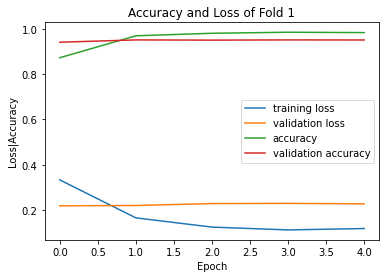

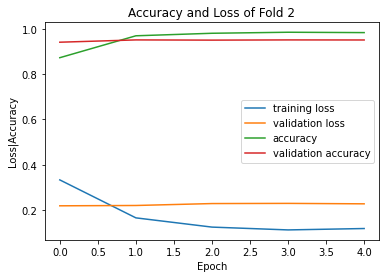

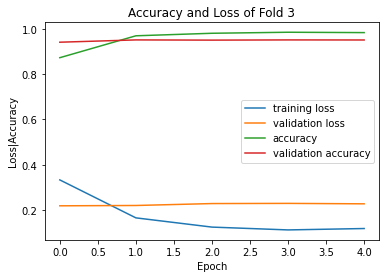

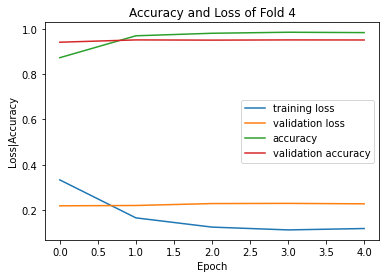

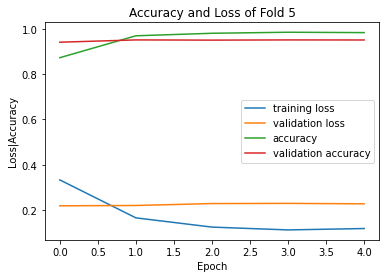

In [ ]:
# Graphing loss, accuracy của traning set and validation set
import matplotlib.pyplot as plt

for fold in sorted(train_df["fold"].unique()):
  fig = plt.figure()
  numOfEpoch = n_epochs
  plt.plot(np.arange(0, numOfEpoch), train_history.history['loss'], label='training loss')
  plt.plot(np.arange(0, numOfEpoch), train_history.history['val_loss'], label='validation loss')
  plt.plot(np.arange(0, numOfEpoch), train_history.history['auc'], label='accuracy')
  plt.plot(np.arange(0, numOfEpoch), train_history.history['val_auc'], label='validation accuracy')
  plt.title('Accuracy and Loss of Fold %d' % (fold+1))
  plt.xlabel('Epoch')
  plt.ylabel('Loss|Accuracy')
  plt.legend()

In [ ]:
# def preprocess_newdata(train_df_path_new):
#     vncore_tokenizer = VnCoreTokenizer()

#     train_df_new = pd.read_csv(train_df_path_new)
#     # test_df = pd.read_csv(test_df_path)

#     train_df_new.insert(2, 'timestamp_post', train_df_new['public_date'])
#     train_df_new.insert(3, 'num_like_post', 0)
#     train_df_new.insert(4, 'num_comment_post', 0)
#     train_df_new.insert(5, 'num_share_post', 0)
#     train_df_new.insert(6, 'label', 0)
  
#     train_df_new['post_message'] = train_df_new['title'] + ". " + train_df_new['content']

#     train_df_new["post_message"] = train_df_new["post_message"].astype(str)
#     # test_df["post_message"] = test_df["post_message"].astype(str)
#     train_df_new['post_message'] = train_df['post_message'].apply(clean_post)
#     train_df_new['post_message'] = train_df_new['post_message'].progress_apply(vncore_tokenizer.tokenize)
  
#     train_df_new["timestamp_post"] = train_df_new["timestamp_post"].astype(float)

#     # test_df["timestamp_post"] = test_df["timestamp_post"].astype(float)
    
#     X_train_new = regular_encode(train_df_new, max_len=MAX_LEN)
#     y_train_new = train_df_new["label"].values

#     train_dataset_new = (
#         tf.data.Dataset.from_tensor_slices((X_train_new, y_train_new))
#         .repeat()
#         .shuffle(64)
#         .batch(BATCH_SIZE)
#         .prefetch(AUTO)
#     )

#     return train_dataset_new

In [ ]:
# def job():
#     print("Starting retraining model with new data ...")
#     now = dt.now()
#     last_day = now - datetime.timedelta(days=1)
#     time = last_day.strftime("%d%m%Y")
#     curr_time = now.strftime("%d%m%Y")

#     #data crawl hôm trước lưu vào file đặt tên theo định dạng newdata_ddmmYYYY.csv
#     train_df_path_new = '/content/drive/MyDrive/github_repos/Fake-news-detection-VN/data/newdata_23112020.csv'      
#     train_df_new = pd.read_csv(train_df_path_new)
#     train_dataset_new = preprocess_newdata(train_df_path_new)

#     model_path = '/content/drive/MyDrive/github_repos/Fake-news-detection-VN/outputs_differ_data/phobert+auxiliary_256_len_models/model_26112020_5.h5'  
#     # model_path = os.path.join(output_dir, f'model_{time}.h5'.format(time=time))
#     curr_model_dir = os.path.join(output_dir, f'model_{curr_time}_retrain.h5'.format(curr_time=curr_time))
    
#     K.clear_session()
#     model = build_model(max_len=MAX_LEN)  
#     model.load_weights(model_path)
#     #lưu model của ngày hiện tại
#     sv = tf.keras.callbacks.ModelCheckpoint(curr_model_dir, 
#                                                 monitor='val_auc', 
#                                                 verbose=1, 
#                                                 save_best_only=False,
#                                                 save_weights_only=True, 
#                                                 mode='max', 
#                                                 save_freq='epoch')
#     #sửa số step, hoặc epoch, reduce learning_rate có thể ko cần ở đây
#     n_epochs = 2
#     n_steps = train_df_new.shape[0]/BATCH_SIZE
#     print("n_steps retrain new data is: ", n_steps)
#     train_history = model.fit(
#         train_dataset_new,
#         steps_per_epoch=n_steps,
#         callbacks=[sv,
#                 # tb,
#                 ],     
#         epochs = n_epochs
#         )

In [ ]:
# job()

In [ ]:
X_test = regular_encode(test_df, max_len=MAX_LEN)
y_test = np.zeros((len(test_df),1))
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_test,y_test))
    .batch(BATCH_SIZE)
)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
model = build_model(max_len=MAX_LEN)
preds = []
for i, file_name in enumerate(os.listdir(output_dir)):
    print('_'*80)
    
    K.clear_session()
    model_path = os.path.join(output_dir, file_name)
    
    print(f'Inferencing with model from: {model_path}')
    model.load_weights(model_path)

    pred = model.predict(test_dataset,
                         batch_size=128,
                         verbose=DISPLAY)
    print(pred)
    preds.append(pred)

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


________________________________________________________________________________
Inferencing with model from: ../outputs_private_data/phobert+auxiliary_256_len_models/08122020/model_08122020_FOLD_1.h5
103/103 [==============================] - 11s 104ms/step
[[0.9221466 ]
 [0.00860333]
 [0.00887156]
 ...
 [0.00543158]
 [0.00446235]
 [0.01185286]]
________________________________________________________________________________
Inferencing with model from: ../outputs_private_data/phobert+auxiliary_256_len_models/08122020/model_08122020_FOLD_2.h5
103/103 [==============================] - 11s 104ms/step
[[0.4205267 ]
 [0.00655384]
 [0.00356111]
 ...
 [0.00564439]
 [0.00308866]
 [0.00577035]]
________________________________________________________________________________
Inferencing with model from: ../outputs_private_data/phobert+auxiliary_256_len_models/08122020/model_08122020_FOLD_3.h5
103/103 [==============================] - 11s 104ms/step
[[0.85245454]
 [0.00860426]
 [0.00344702]
 

In [ ]:
# model = build_model(max_len=MAX_LEN)
# preds = []

# K.clear_session()
# model_path = '/content/drive/MyDrive/github_repos/Fake-news-detection-VN/outputs/phobert+auxiliary_256_len_models/model_25112020_1.h5'
    
# print(f'Inferencing with model from: {model_path}')
# model.load_weights(model_path)

# pred = model.predict(test_dataset,
#                          batch_size=128,
#                          verbose=DISPLAY)
# print(pred)
# preds.append(pred)

In [ ]:
preds = np.mean(preds, axis=0)
test_df["prediction"] = preds
test_df["prediction"].to_csv(f"/content/drive/MyDrive/github_repos/Fake-news-detection-VN/outputs_private_data/results.csv", header=False)

In [ ]:
# def predict():

#     preds = []
#     test_df_path = '/content/drive/MyDrive/DATN/Fake-detect/data/test.csv'
#     train_df_path = '/content/drive/MyDrive/DATN/Fake-detect/data/train_5_folds.csv'
#     K.clear_session()

#     now = dt.now()
#     last_day = now - datetime.timedelta(days=1)
#     time = last_day.strftime("%d%m%Y")

#     #đường dẫn dến file model hôm trước, tên file model có dạng model_ddmmYYYY.h5
#     model_path = '/content/drive/MyDrive/github_repos/Fake-news-detection-VN/outputs/phobert+auxiliary_256_len_models/model_24112020_retrain.h5'
#     model = build_model(max_len=MAX_LEN)
#     model.load_weights(model_path)
#     pred = model.predict(test_dataset,
#                           batch_size=128,
#                           verbose=DISPLAY)
#     # print(pred[])
#     preds.append(pred)
#     preds = np.mean(preds, axis=0)
#     test_df["prediction"] = preds
#     test_df["prediction"].to_csv(f"{exp}.csv", header=False)

In [38]:
data_test = [{'post_message': '3 công nhân trung quốc làm cty hòa phát bị nhiễm visrut corona là sự thật mọi người đề phòng mặc dù hòa phát ngăn chặn yếm mọi thông tin nhưng công nhân làm ở hòa phát đã nói lại sự thật trên... mình đăng tin này có thể bị lực lượng chức năng ngăn chặn nguồn tin và xử phạt và bắt giữ mình nhưng mình cũng muốn nói vì đó là sự thật. sau 1 giờ mình sẽ xóa tin này vì k muốn bị lực lượng nhà nước cưỡng chế áp giải bắt bớ mình dù đó là sự thật.' ,
              'timestamp_post': 1596255660, 
              'num_like_post': 0 , 
              'num_comment_post': 0, 
              'num_share_post': 0}] 
df_test_1 = pd.DataFrame(data_test) 

In [39]:
def predict(df_test_1):
  
  df_test_1['post_message'] = df_test_1['post_message'].apply(clean_post)
  df_test_1["post_message"] = df_test_1["post_message"].progress_apply(vncore_tokenizer.tokenize)

  df_test_1["post_message"] = df_test_1["post_message"].astype(str)

  df_test_1["timestamp_post"] = df_test_1["timestamp_post"].astype(float)

  for col in ["timestamp_post", "num_like_post", "num_comment_post", "num_share_post"]:
    df_test_1[col] = df_test_1[col].apply(extract_num)
    df_test_1[col] = df_test_1[col].astype(float)
    df_test_1[col] = df_test_1[col].fillna(0)

  X_test = regular_encode(df_test_1, max_len=MAX_LEN)
  y_test = np.zeros((len(df_test_1),1))
  
  model = build_model(max_len=MAX_LEN)
  preds = []
  for i, file_name in enumerate(os.listdir(output_dir)):
      print('_'*80)
      
      K.clear_session()
      model_path = os.path.join(output_dir, file_name)
      
      print(f'Inferencing with model from: {model_path}')
      model.load_weights(model_path)

      pred = model.predict(X_test, y_test)
      print(pred)
      preds.append(pred)
  preds = np.mean(preds, axis=0)
  print(preds)
predict(df_test_1)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exact

________________________________________________________________________________
Inferencing with model from: /content/drive/MyDrive/github_repos/Fake-news-detection-VN/outputs_private_data/phobert+auxiliary_256_len_models/08122020/model_08122020_FOLD_1.h5
[[0.9815452]]
________________________________________________________________________________
Inferencing with model from: /content/drive/MyDrive/github_repos/Fake-news-detection-VN/outputs_private_data/phobert+auxiliary_256_len_models/08122020/model_08122020_FOLD_2.h5
[[0.97393525]]
________________________________________________________________________________
Inferencing with model from: /content/drive/MyDrive/github_repos/Fake-news-detection-VN/outputs_private_data/phobert+auxiliary_256_len_models/08122020/model_08122020_FOLD_3.h5
[[0.9605708]]
________________________________________________________________________________
Inferencing with model from: /content/drive/MyDrive/github_repos/Fake-news-detection-VN/outputs_private_d